<a href="https://colab.research.google.com/github/axel-sirota/tf-dev-nlp/blob/main/module5/TF_Developer_NLP_Module5_Solution_Text_Generation_Words.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Generating Support like responses


Let's first import everything and load the dataset

In [97]:
!pip install textblob 'gensim==4.2.0' 'keras-nlp' swifter

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [98]:
import multiprocessing
import tensorflow as tf
import sys
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, Embedding, Lambda, ELU, Conv1D, MaxPooling1D, Dropout
from keras.utils import np_utils
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from keras import preprocessing
from textblob import TextBlob, Word
from keras_preprocessing.sequence import pad_sequences
from keras.initializers import Constant
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import Model, Input
from collections import defaultdict
import keras_nlp
import swifter
import numpy as np
import re
import random
import os
import pandas as pd
import gensim
import warnings
import nltk
import time

TRACE = False
embedding_dim = 128
rnn_units = 1024
epochs=15
buffer_size = 2000
batch_size = 256
min_count_words = 5
fraction_corpus = 0.01
BATCH = True

def set_seeds_and_trace():
  os.environ['PYTHONHASHSEED'] = '0'
  np.random.seed(42)
  tf.random.set_seed(42)
  random.seed(42)
  if TRACE:
    tf.debugging.set_log_device_placement(True)

def set_session_with_gpus_and_cores():
  cores = multiprocessing.cpu_count()
  gpus = len(tf.config.list_physical_devices('GPU'))
  config = tf.compat.v1.ConfigProto( device_count = {'GPU': gpus  , 'CPU': cores} , intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
  sess = tf.compat.v1.Session(config=config) 
  K.set_session(sess)

set_seeds_and_trace()
set_session_with_gpus_and_cores()
warnings.filterwarnings('ignore')
nltk.download('punkt')
tokenizer = lambda x: TextBlob(x).words

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Now we will download the dataset and explore it

In [99]:
%%writefile get_data.sh
if [ ! -f twitter.csv ]; then
  wget -O twitter.csv https://www.dropbox.com/s/hjji6x6vx4wno1c/twcs.csv?dl=0
fi

if [ ! -f glove.6B.100d.txt ]; then
  wget -O glove.6B.100d.txt https://www.dropbox.com/s/dl1vswq2sz5f1ws/glove.6B.100d.txt?dl=0
fi

Overwriting get_data.sh


In [100]:
!bash get_data.sh


Let's inspect how this intents csv looks like

In [101]:
! head twitter.csv

tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
1,sprintcare,False,Tue Oct 31 22:10:47 +0000 2017,@115712 I understand. I would like to assist you. We would need to get you into a private secured link to further assist.,2,3
2,115712,True,Tue Oct 31 22:11:45 +0000 2017,@sprintcare and how do you propose we do that,,1
3,115712,True,Tue Oct 31 22:08:27 +0000 2017,@sprintcare I have sent several private messages and no one is responding as usual,1,4
4,sprintcare,False,Tue Oct 31 21:54:49 +0000 2017,@115712 Please send us a Private Message so that we can further assist you. Just click ‘Message’ at the top of your profile.,3,5
5,115712,True,Tue Oct 31 21:49:35 +0000 2017,@sprintcare I did.,4,6
6,sprintcare,False,Tue Oct 31 21:46:24 +0000 2017,"@115712 Can you please send us a private message, so that I can gain further details about your account?","5,7",8
8,115712,True,Tue Oct 31 21:45:10 +0000 2017,@sprintcare is the worst customer service,"9,6,10",
11,s

In [102]:
def preprocess_text(text, should_join=True):
    text = ' '.join(word.lower() for word in text.split(" "))
    text = re.sub(r"(\@\d+)", r" ", text) # remove twitter handle
    text = re.sub(r"(https\:\/\/t.co\/\w+)", r" ", text) # remove end twtter url
    text = re.sub(r"([.,!?])", r" ", text) # remove punctuation
    text = re.sub(r"[^a-zA-Z.,&!?]+", r" ", text) # only normal characters
    if should_join:
      return ' '.join(gensim.utils.simple_preprocess(text))
    else:
      return gensim.utils.simple_preprocess(text)

In [103]:
path = './twitter.csv'
twitter = pd.read_csv(path, header=0)
twitter

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
0,1,sprintcare,False,Tue Oct 31 22:10:47 +0000 2017,@115712 I understand. I would like to assist y...,2,3.0
1,2,115712,True,Tue Oct 31 22:11:45 +0000 2017,@sprintcare and how do you propose we do that,NaN,1.0
2,3,115712,True,Tue Oct 31 22:08:27 +0000 2017,@sprintcare I have sent several private messag...,1,4.0
3,4,sprintcare,False,Tue Oct 31 21:54:49 +0000 2017,@115712 Please send us a Private Message so th...,3,5.0
4,5,115712,True,Tue Oct 31 21:49:35 +0000 2017,@sprintcare I did.,4,6.0
...,...,...,...,...,...,...,...
2811769,2987947,sprintcare,False,Wed Nov 22 08:43:51 +0000 2017,"@823869 Hey, we'd be happy to look into this f...",NaN,2987948.0
2811770,2987948,823869,True,Wed Nov 22 08:35:16 +0000 2017,@115714 wtf!? I’ve been having really shitty s...,2987947,NaN
2811771,2812240,121673,True,Thu Nov 23 04:13:07 +0000 2017,@143549 @sprintcare You have to go to https://...,NaN,2812239.0
2811772,2987949,AldiUK,False,Wed Nov 22 08:31:24 +0000 2017,"@823870 Sounds delicious, Sarah! 😋 https://t.c...",NaN,2987950.0


In [104]:
twitter[twitter.inbound == False ].author_id.value_counts()

AmazonHelp        169840
AppleSupport      106860
Uber_Support       56270
SpotifyCares       43265
Delta              42253
                   ...  
JackBox              266
OfficeSupport        218
AskDSC               210
CarlsJr              196
HotelTonightCX       152
Name: author_id, Length: 108, dtype: int64

In [105]:
twitter_filtered = twitter[twitter.inbound == False ].groupby('author_id').filter(lambda x: len(x) >= 10000).sample(frac=fraction_corpus).reset_index()
twitter_filtered.author_id.value_counts()

AmazonHelp         1742
AppleSupport       1041
Uber_Support        542
SpotifyCares        443
AmericanAir         396
Delta               394
Tesco               371
TMobileHelp         342
comcastcares        340
British_Airways     297
SouthwestAir        292
Ask_Spectrum        268
VirginTrains        266
XboxSupport         252
AskPlayStation      213
sainsburys          208
sprintcare          207
hulu_support        203
UPSHelp             199
ChipotleTweets      186
GWRHelp             185
VerizonSupport      185
ATVIAssist          177
idea_cares          166
Safaricom_Care      160
O2                  151
BofA_Help           135
AskPayPal           130
AskTarget           127
ArgosHelpers        120
SW_Help             116
marksandspencer     113
Morrisons           112
AirAsiaSupport      110
MicrosoftHelps      110
AskAmex             106
AskLyft             102
Name: author_id, dtype: int64

In [106]:
responses = twitter_filtered.reset_index(drop=True).text
responses

0        @340426 Apologies! We currently don't support ...
1        @130645 Hi, please let us know if you have a s...
2        @820651 Sure Ahmed, may we have the booking nu...
3        @223341 I'm sorry to hear that you did not rec...
4        @399801 traffic through this area to keep the ...
                               ...                        
10502    @726229 Hey there, can you send me a PM at the...
10503    @808685 We're providing options to our AAdvant...
10504    @298949 Hi Tom, as there are engineering works...
10505    @743553 Sure! That’d be at gate C20 in Termina...
10506    @544947 Great. How long ago did you notice thi...
Name: text, Length: 10507, dtype: object

In [107]:
responses[0]

"@340426 Apologies! We currently don't support off line streaming, but we'll express your interest in seeing this option in the future."

In [108]:
processed_responses = responses.swifter.apply(preprocess_text)

Pandas Apply:   0%|          | 0/10507 [00:00<?, ?it/s]

In [109]:
processed_responses[0]

'apologies we currently don support off line streaming but we ll express your interest in seeing this option in the future'

In [110]:
vocab = set()
counts = defaultdict(int)
for ix, response in processed_responses.iteritems():
    for word in preprocess_text(response, should_join=False):
        counts[word] += 1
        if counts[word] > min_count_words:
          vocab.add(word)
vocab = sorted(vocab)

In [111]:
print(f'{len(vocab)} unique words')

2224 unique words


In [112]:
def get_maximum_review_length(srs):
    maximum = 0
    for response in srs:
        candidate = len(preprocess_text(response, should_join=False))
        if candidate > maximum:
            maximum = candidate
    return maximum


maximum = get_maximum_review_length(processed_responses)

In [113]:
maximum

56

In [114]:

ids_from_words = preprocessing.StringLookup(vocabulary=list(vocab), mask_token=None)
ids_from_words

In [115]:

words_from_ids = preprocessing.StringLookup(
    vocabulary=ids_from_words.get_vocabulary(), invert=True, mask_token=None)


In [116]:
def text_from_ids(ids):
  return tf.strings.reduce_join(words_from_ids(ids), axis=-1, separator=' ')


In [117]:
word_to_ix = {}
for word in vocab:
  ix = ids_from_words(word)
  word_to_ix[word] = ix.numpy()

In [118]:
ids = ids_from_words(preprocess_text('Only you can prevent forest fires', should_join=False))
ids

<tf.Tensor: shape=(6,), dtype=int64, numpy=array([1370, 2216,  281, 1499,    0,    0])>

In [119]:
for word in preprocess_text('Only you can prevent forest fires', should_join=False):
  print(f'Word:{word}, ix:{word_to_ix.get(word, 0)}')

Word:only, ix:1370
Word:you, ix:2216
Word:can, ix:281
Word:prevent, ix:1499
Word:forest, ix:0
Word:fires, ix:0


In [120]:
text_from_ids(ids)


<tf.Tensor: shape=(), dtype=string, numpy=b'only you can prevent [UNK] [UNK]'>

## Embedding matrix

In [121]:
path_to_glove_file = "./glove.6B.100d.txt"
embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400001 word vectors.


In [122]:
embedding_dim = 100
num_tokens = len(vocab) + 1
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, ix in word_to_ix.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[ix] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 2159 words (65 misses)


## Creating the corpus and tokenizing

In [123]:
X_train, X_test = train_test_split(processed_responses, test_size=0.2, random_state=42)
X_train

7856    hi thanks for the tweet really sorry but there...
2531    please check the following link for any update...
3320    sounds like you need my expertise please dm qu...
5359    does anyone have access to your phone as this ...
617     sorry this happened let us review this for you...
                              ...                        
5734    we be happy to look into this issue send us dm...
5191    was pretty pumped to see mhz coverage device t...
5390    sorry sean we don have any details regarding t...
860     can you please follow this link for me so can ...
7270    apologies for the unpleasant experience kindly...
Name: text, Length: 8405, dtype: object

In [124]:
def pad_sequence_of_tokens(x, maxlen, unk_token='[UNK]'):
  if len(x)<maxlen:
    x.extend([unk_token]*(maxlen-len(x)))
  return x

In [125]:

def get_ids_tensor(srs):
  
  processed = srs.swifter.apply(lambda x: pad_sequence_of_tokens(preprocess_text(x, should_join=False), maxlen=maximum)).to_list()
  return tf.squeeze(tf.constant(pad_sequences(ids_from_words(processed), maxlen=maximum, padding='post'), dtype='int32'))



In [126]:
all_ids = get_ids_tensor(srs=X_train.reset_index(drop=True))
all_ids

Pandas Apply:   0%|          | 0/8405 [00:00<?, ?it/s]

<tf.Tensor: shape=(8405, 56), dtype=int32, numpy=
array([[ 874, 1963,  750, ...,    0,    0,    0],
       [1465,  335, 1966, ...,    0,    0,    0],
       [1839, 1107, 2216, ...,    0,    0,    0],
       ...,
       [1835, 1726, 2145, ...,    0,    0,    0],
       [ 281, 2216, 1465, ...,    0,    0,    0],
       [ 118,  750, 1966, ...,    0,    0,    0]], dtype=int32)>

In [127]:
all_ids.shape

TensorShape([8405, 56])

In [128]:
test_all_ids = get_ids_tensor(srs=X_test)

Pandas Apply:   0%|          | 0/2102 [00:00<?, ?it/s]

In [129]:
ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)
test_ids_dataset = tf.data.Dataset.from_tensor_slices(test_all_ids)

In [130]:
def split_input_target(sequence):
    input_text = sequence[:-1]
    target_text = sequence[1:]
    return input_text, target_text

In [131]:
dataset = ids_dataset.map(split_input_target)
test_dataset = test_ids_dataset.map(split_input_target)

In [132]:
for input_example, target_example in dataset.take(1):
    print("Input :", text_from_ids(input_example).numpy())
    print("Target:", text_from_ids(target_example).numpy())

Input : b'hi thanks for the tweet really sorry but there is [UNK] here now who can answer your query you would need to contact us on after on friday and ask to be put through to our [UNK] team they will be able to resolve this for you thanks mark [UNK] [UNK] [UNK] [UNK] [UNK] [UNK]'
Target: b'thanks for the tweet really sorry but there is [UNK] here now who can answer your query you would need to contact us on after on friday and ask to be put through to our [UNK] team they will be able to resolve this for you thanks mark [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK]'


In [133]:

shuffled_batched_dataset = (
    dataset
    .shuffle(buffer_size)
    .batch(batch_size=batch_size, drop_remainder=True)
)
shuffled_batched_test_dataset = (
    test_dataset
    .shuffle(buffer_size)
    .batch(batch_size=batch_size, drop_remainder=True)
)

## Doing the train_test split and defining model

In [134]:
class RentalGenerator(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super().__init__(self)
    self.embedding = Embedding(input_dim=embedding_matrix.shape[0], output_dim=embedding_matrix.shape[1], embeddings_initializer=Constant(embedding_matrix), trainable=False)
    # self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.rnn = tf.keras.layers.LSTM(rnn_units,
                                   activation='tanh',
                                   return_sequences=True,
                                   return_state=True)
    self.dense = tf.keras.layers.Dense(vocab_size)

  def call(self, inputs, states=None, return_state=False, training=False):
    x = inputs
    x = self.embedding(x, training=training)
    if states is None:
      states = self.rnn.get_initial_state(x)
    output = self.rnn(x, initial_state=states, training=training)
    x = output[0]
    states = output[1:]
    x = self.dense(x, training=training)

    if return_state:
      return x, states
    else:
      return x
  
  def build_graph(self, maxlen):
    x = Input(shape=(maxlen, ))
    return Model(inputs=x, outputs=self.call(x))

In [135]:
model = RentalGenerator(
    # Be sure the vocabulary size matches the `StringLookup` layers.
    vocab_size=len(ids_from_words.get_vocabulary()),
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

In [136]:
for input_example_batch, target_example_batch in shuffled_batched_dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(input_example_batch.shape, "# Input: (batch_size, sequence_length)")
    print(example_batch_predictions.shape, "# Output: (batch_size, sequence_length, vocab_size)")

(256, 55) # Input: (batch_size, sequence_length)
(256, 55, 2225) # Output: (batch_size, sequence_length, vocab_size)


In [137]:
model.build_graph(maxlen=maximum)  # Notice the change in outputs!

In [138]:
model.summary()

Model: "rental_generator_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 56, 100)           222500    
                                                                 
 lstm_2 (LSTM)               [(None, 56, 1024),        4608000   
                              (None, 1024),                      
                              (None, 1024)]                      
                                                                 
 dense_2 (Dense)             (None, 56, 2225)          2280625   
                                                                 
Total params: 7,111,125
Trainable params: 6,888,625
Non-trainable params: 222,500
_________________________________________________________________


In [139]:
perplexity = keras_nlp.metrics.Perplexity(from_logits=True, name='perplexity', mask_token_id=0)
model.compile(optimizer='adam', loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=[perplexity])


Notice the non-trainable parameters

In [140]:
history = model.fit(shuffled_batched_dataset, epochs=epochs, workers=5, validation_data=shuffled_batched_test_dataset)


Epoch 1/15
32/32 [==============================] - 3s 41ms/step - loss: 2.5429 - perplexity: 845.1703 - val_loss: 1.9162 - val_perplexity: 435.3210
Epoch 2/15
32/32 [==============================] - 1s 25ms/step - loss: 1.8818 - perplexity: 365.1218 - val_loss: 1.8092 - val_perplexity: 318.4598
Epoch 3/15
32/32 [==============================] - 1s 25ms/step - loss: 1.7833 - perplexity: 270.3958 - val_loss: 1.7174 - val_perplexity: 235.5533
Epoch 4/15
32/32 [==============================] - 1s 26ms/step - loss: 1.6768 - perplexity: 194.8723 - val_loss: 1.6218 - val_perplexity: 171.5523
Epoch 5/15
32/32 [==============================] - 1s 26ms/step - loss: 1.5852 - perplexity: 144.9660 - val_loss: 1.5449 - val_perplexity: 134.7244
Epoch 6/15
32/32 [==============================] - 1s 26ms/step - loss: 1.5098 - perplexity: 114.2524 - val_loss: 1.4903 - val_perplexity: 112.4744
Epoch 7/15
32/32 [==============================] - 1s 25ms/step - loss: 1.4508 - perplexity: 95.1214 - va

## Some plots

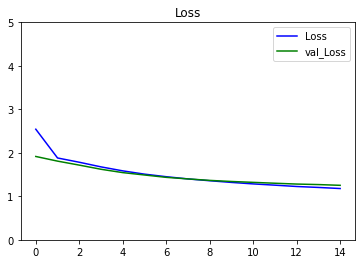

In [141]:
import matplotlib.pyplot as plt
# function for plotting loss
def plot_metrics(train_metric, val_metric=None, metric_name=None, title=None, ylim=5):
    plt.title(title)
    plt.ylim(0,ylim)
    plt.plot(train_metric,color='blue',label=metric_name)
    if val_metric is not None: plt.plot(val_metric,color='green',label='val_' + metric_name)
    plt.legend(loc="upper right")

# plot loss history
plot_metrics(history.history['loss'], history.history['val_loss'], "Loss", "Loss", ylim=5.0)


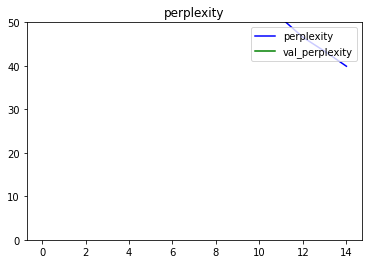

In [142]:
plot_metrics(history.history['perplexity'], val_metric=history.history['val_perplexity'], metric_name="perplexity", title="perplexity", ylim=50.0)


In [143]:

class OneStep(tf.keras.Model):
  def __init__(self, model, word_from_ids, ids_from_words, temperature=1.0):
    super().__init__()
    self.temperature = temperature
    self.model = model
    self.word_from_ids = word_from_ids
    self.ids_from_words = ids_from_words

    # Create a mask to prevent "[UNK]" from being generated.
    skip_ids = self.ids_from_words(['[UNK]'])[:, None]
    sparse_mask = tf.SparseTensor(
        # Put a -inf at each bad index.
        values=[-float('inf')]*len(skip_ids),
        indices=skip_ids,
        # Match the shape to the vocabulary
        dense_shape=[len(ids_from_words.get_vocabulary())])
    self.prediction_mask = tf.sparse.to_dense(sparse_mask)

  @tf.function(reduce_retracing=True)
  def expand_dims_if_neccesary(self, input):
    if len(input.shape) < 3:
      input = tf.expand_dims(input, axis=0)
    return input

  @tf.function(reduce_retracing=True)
  def generate_one_step(self, inputs, states=None):
    # Convert strings to token IDs.
    input_words = preprocess_text(inputs, should_join=False)
    input_ids = self.expand_dims_if_neccesary(self.ids_from_words(input_words))
    # Run the model.
    # predicted_logits.shape is [batch, char, next_char_logits]
    predicted_logits, states = self.model(inputs=input_ids, states=states,
                                          return_state=True)
    # Only use the last prediction.
    predicted_logits = predicted_logits[:, -1, :]
    predicted_logits = predicted_logits/self.temperature
    # Apply the prediction mask: prevent "[UNK]" from being generated.
    predicted_logits = predicted_logits + self.prediction_mask

    # Sample the output logits to generate token IDs.
    predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
    predicted_ids = tf.squeeze(predicted_ids, axis=-1)

    # Convert from token ids to characters
    predicted_word = self.word_from_ids(predicted_ids)

    # Return the characters and model state.
    return predicted_word, states

In [144]:
one_step_model = OneStep(model, words_from_ids, ids_from_words)
start = time.time()
states = None
response = tf.constant(['Hi! We are sorry'])
# result = [description]

for n in range(100):
  next_word, states = one_step_model.generate_one_step(response.numpy()[0].decode(), states=states)
  response = tf.concat([response, next_word], axis=0)


result = tf.strings.join(response, separator=" ")
end = time.time()
print(result, '\n\n' + '_'*80)
print('\nRun time:', end - start)


tf.Tensor(b'Hi! We are sorry to to about for we to about so about that for to reply to please for to about to for to for thanks for to for for paul for confirm about for if to to for can to this for about contacted to for thanks to forward to about thanks you for you to reached about about about for na for to about to to for few for your it time can the to could to for able to can dm good about james about about to again to about about for to about about that for to for for', shape=(), dtype=string) 

________________________________________________________________________________

Run time: 0.935847282409668
